# Chapter 9. Modern RNN

- Topics
  - two widely used networks, GRU & LSTM, 
  - single layer => multi layer (deeper RNN)
  - unidirectional => bidirectional 
  - sequence to sequence
  - encoder-decoder

## Gated Recurrent Units (GRU)

- RNN에서의 Gradient update 관련 문제점들(explosion or vanish)이 영향 예시
  
  - sequence의 first part가 매우 중요한 역할을 한는 경우 (sequence 앞에 checksum이 있다던가...)
    - 매우 중요한 sequence의 first part를 memory cell에 저장
    - 혹은 위와 같은 memory cell이 없다면, 이 중요한 부분에 매우 큰 gradient를 할당
  
  - 혹은 반대로 어떠한 연관성도 없는 token들이 존재 (Web Content의 HTML code같이..)
    - some mechanism to skip
    
  - sequence들 간의 논리적 분리가 존재. (가령 다른 chapter로 넘어가는 부분)
    - some mechanism to reset hidden state 

- 이러한 문제점을 해소하기 위하여 다양한 방법이 제안...
  - Long Short-term memory
  - Gated recurrent unit
    - LSTM 대비 비슷한 성능 수준 / Faster compute

### Gated Hidden State

- Gating mechanism
  - hidden state의 update 혹은 reset을 결정하는 mechanism이 존재
  - 예를들어 first token이 중요하다면 first token 이후 hidden state를 update하지 않음.
  - 반대로 관련성이 낮은 token을 skip
  - 필요할 때 latent state를 reset

#### Reset Gate and Update Gate

- Reset Gate => ```얼마나 많은 이전 step의 상태를 기억할지```를 제어
- Update Gate => ```얼마나 많은 latent state가 update 되지 않고 단지 copy 될지```를 제어
- Reset gate와 update gate 제어를 위한 parameter R_t, Z_t
  - 모두 입력 X_t, H_t-1의 함수
    - R_t = sigmoid (X_t W_xr + H_t-1 W_hr + b_r)
    - Z_t = sigmoid (X_t W_xz + H_t-1 W_hz + b_z)

#### Candidate Hidden State
- Reset parameter의 term이 고려된 Hidden state
- Update parameter는 아직 고려 안됨
- H_hat_t = tanh(X_t W_xh + elewise_prod(R_t, H_t-1) W_hh + b_h)

#### Hidden State (complete)
- H_t = elewise_prd(Z_t, H_t-1) + elewise_prd((1 - Z_t), H_hat_t)
- Z_t 가 1에 가까우면 old state를 보유
- Z_t 가 0에 가까우면 candidate hidden state를 새로운 state로 사용

### Implementation GRU from scratch


In [8]:
import torch 
from torch import nn
from d2l import torch as d2l

batch_size, num_steps = 32, 35
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)
len(vocab)

28

In [10]:
def get_params(vocab_size, num_hiddens, device):
    num_inputs = num_outputs = vocab_size
    
    def normal(shape):
        return torch.randn(size=shape, device=device) * 0.01
    
    def three():
        return (normal((num_inputs, num_hiddens)), 
               normal((num_hiddens, num_hiddens)),
               torch.zeros(num_hiddens, device=device))
    
    
    W_xz, W_hz, b_z = three()
    W_xr, W_hr, b_r = three()
    W_xh, W_hh, b_h = three()
    
    W_hq = normal((num_hiddens, num_outputs))
    b_q = torch.zeros(num_outputs, device=device)
    
    params = [W_xz, W_hz, b_z, W_xr, W_hr, b_r, W_xh, W_hh, b_h, W_hq, b_q]
    for param in params:
        param.requires_grad_(True)
    return params


#### Defining Model

In [12]:
def init_gru_state(batch_size, num_hiddens, device):
    return (torch.zeros((batch_size, num_hiddens), device=device), )

def gru(inputs, state, params):
    W_xz, W_hz, b_z, W_xr, W_hr, b_r, W_xh, W_hh, b_h, W_hq, b_q = params
    H, = state
    outputs = []
    for X in inputs:
        Z = torch.sigmoid((X @ W_xz) + (H @ W_hz) + b_z) 
        R = torch.sigmoid((X @ W_xr) + (H @ W_hr) + b_r)
        H_tilda = torch.tanh((X @ W_xh) + ((R * H) @ W_hh) + b_h)
        H = Z * H + (1 - Z) * H_tilda 
        Y = H @ W_hq + b_q
        outputs.append(Y)
    return torch.cat(outputs, dim=0), (H,)

#### Training and Predicting


perplexity 1.1, 44246.3 tokens/sec on cuda:0
time travellerit would be remarkably convenient for the historia
travellerit tous exist now it but some foolishpeople have g


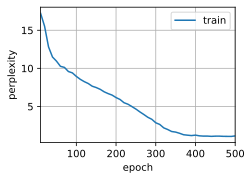

In [14]:
vocab_size, num_hiddens, device = len(vocab), 256, d2l.try_gpu()
num_epochs, lr = 500, 1
model = d2l.RNNModelScratch(len(vocab), num_hiddens, device, get_params, init_gru_state, gru)

d2l.train_ch8(model, train_iter, vocab, lr, num_epochs, device)

### Concise Implementation 

perplexity 1.0, 196007.8 tokens/sec on cuda:0
time traveller for so it will be convenient to speak of himwas e
travelleryou can show black is white by argument said filby


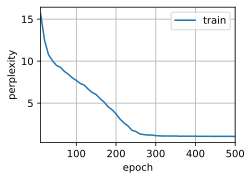

In [15]:
num_inputs = vocab_size
gru_layer = nn.GRU(num_inputs, num_hiddens)
model = d2l.RNNModel(gru_layer, len(vocab))
model = model.to(device)
d2l.train_ch8(model, train_iter, vocab, lr, num_epochs, device)

## Long Short-Term Memory (LSTM)
- Long term information preservation
- Short term input skip 
- GRU 보다 약 20년 먼저 나왔지만 LSTM이 약간 더 복잡함. 

### Gated Memory Cell
- 컴퓨터의 논리소자 logic gate를 모방
- 
